In [1]:
from gym.wrappers import FilterObservation, FlattenObservation, RecordVideo, RescaleAction, TimeLimit
import matplotlib.pyplot as plt
import numpy as np
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.env_util import unwrap_wrapper

from train import ARESEACheetah, ARESEADOOCS
from utils import FilterAction, RecordData

In [2]:
env = ARESEACheetah(
    action_type="direct",
    incoming="random",
    incoming_parameters=None,
    magnet_init="zero",
    misalignments="random",
    misalignment_values=None,
    reward_method="feedback",
    quad_action="oneway",
    target_beam_mode="zero",
    target_beam_tolerance=3.3198e-6,
    w_mu_x=0.0,
    w_mu_y=0.0,
    w_on_screen=1.0,
    w_sigma_x=1.0,
    w_sigma_y=1.0,
    w_time=0.0
)
env = RescaleAction(env, -1, 1)

check_env(env)

In [3]:
env.observation_space

Dict(beam:Box([-inf   0. -inf   0.], [inf inf inf inf], (4,), float32), incoming:Box([ 8.e+07 -1.e-03 -1.e-04 -1.e-03 -1.e-04  1.e-05  1.e-06  1.e-05  1.e-06
  1.e-06  1.e-04], [1.6e+08 1.0e-03 1.0e-04 1.0e-03 1.0e-04 5.0e-04 5.0e-05 5.0e-04 5.0e-05
 5.0e-05 1.0e-03], (11,), float32), magnets:Box([ 0.0000e+00 -7.2000e+01 -6.1782e-03  0.0000e+00 -6.1782e-03], [7.2000e+01 0.0000e+00 6.1782e-03 7.2000e+01 6.1782e-03], (5,), float32), misalignments:Box([-0.0004 -0.0004 -0.0004 -0.0004 -0.0004 -0.0004 -0.0004 -0.0004], [0.0004 0.0004 0.0004 0.0004 0.0004 0.0004 0.0004 0.0004], (8,), float32), target:Box([-inf   0. -inf   0.], [inf inf inf inf], (4,), float32))

In [4]:
env.reset()

{'beam': array([ 0.00079951,  0.00013675, -0.00059822,  0.00011559], dtype=float32),
 'magnets': array([0., 0., 0., 0., 0.], dtype=float32),
 'target': array([0., 0., 0., 0.], dtype=float32),
 'incoming': array([ 1.04765144e+08,  9.69192421e-04,  4.48792380e-05, -8.72867007e-04,
        -5.89814736e-05,  1.07587635e-04,  4.12562222e-05,  9.73612041e-05,
         3.04527839e-05,  3.35517034e-05,  6.36427721e-04], dtype=float32),
 'misalignments': array([ 1.6742801e-04, -1.5946323e-04, -2.2526544e-04, -1.9879293e-04,
        -8.2288883e-05, -8.9532536e-05,  2.6150252e-04, -3.9532792e-04],
       dtype=float32)}

In [5]:
env.step(env.action_space.sample())

({'beam': array([-0.0009761 ,  0.00013759,  0.00712754,  0.00094694], dtype=float32),
  'magnets': array([ 5.3507433e+00, -3.9401001e+01,  2.6312377e-04,  3.0371754e+01,
          1.9857478e-03], dtype=float32),
  'target': array([0., 0., 0., 0.], dtype=float32),
  'incoming': array([ 1.04765144e+08,  9.69192421e-04,  4.48792380e-05, -8.72867007e-04,
         -5.89814736e-05,  1.07587635e-04,  4.12562222e-05,  9.73612041e-05,
          3.04527839e-05,  3.35517034e-05,  6.36427721e-04], dtype=float32),
  'misalignments': array([ 1.6742801e-04, -1.5946323e-04, -2.2526544e-04, -1.9879293e-04,
         -8.2288883e-05, -8.9532536e-05,  2.6150252e-04, -3.9532792e-04],
        dtype=float32)},
 -2.006116271018982,
 False,
 {'mu_x_reward': -1.2208657,
  'mu_y_reward': -11.914635,
  'on_screen_reward': -1,
  'sigma_x_reward': -1.0061163,
  'sigma_y_reward': -8.19209,
  'time_reward': -1})

In [8]:
env = ARESEADOOCS(
    action_type="direct",
    incoming="random",
    incoming_parameters=None,
    magnet_init="zero",
    misalignments="random",
    misalignment_values=None,
    reward_method="feedback",
    quad_action="oneway",
    target_beam_mode="zero",
    target_beam_tolerance=3.3198e-6,
    w_mu_x=0.0,
    w_mu_y=0.0,
    w_on_screen=1.0,
    w_sigma_x=1.0,
    w_sigma_y=1.0,
    w_time=0.0
)
env = RescaleAction(env, -1, 1)

check_env(env)

In [9]:
env.observation_space

Dict(beam:Box([-inf   0. -inf   0.], [inf inf inf inf], (4,), float32), magnets:Box([ 0.0000e+00 -7.2000e+01 -6.1782e-03  0.0000e+00 -6.1782e-03], [7.2000e+01 0.0000e+00 6.1782e-03 7.2000e+01 6.1782e-03], (5,), float32), target:Box([-inf   0. -inf   0.], [inf inf inf inf], (4,), float32))

In [10]:
env.reset()

{'beam': array([0.00095108, 0.00138637, 0.00041876, 0.00135623], dtype=float32),
 'magnets': array([0., 0., 0., 0., 0.], dtype=float32),
 'target': array([0., 0., 0., 0.], dtype=float32)}

In [12]:
env.step(env.action_space.sample())

({'beam': array([-7.0975998e-06,  3.6829161e-03, -2.8106496e-03,  2.4110743e-05],
        dtype=float32),
  'magnets': array([ 3.1164124e+01, -2.6183014e+01, -1.7265235e-03,  3.6120426e+01,
         -5.5903802e-03], dtype=float32),
  'target': array([0., 0., 0., 0.], dtype=float32)},
 -2.656521739130435,
 False,
 {'mu_x_reward': -0.007462686567164179,
  'mu_y_reward': -6.711864406779662,
  'on_screen_reward': 0,
  'sigma_x_reward': -2.656521739130435,
  'sigma_y_reward': -0.017777777777777778,
  'time_reward': -1})

Setting AREAMQZM3 to 0.0
Setting AREAMQZM3 to 40.07249069213867
Setting AREAMQZM3 to 26.623470306396484
Setting AREAMQZM3 to 11.613805770874023
Setting AREAMQZM3 to 17.369447708129883
Setting AREAMQZM3 to 58.93876647949219
Setting AREAMQZM3 to 64.96320343017578
Setting AREAMQZM3 to 6.840712547302246
Setting AREAMQZM3 to 33.95187759399414
Setting AREAMQZM3 to 37.42599868774414
Setting AREAMQZM3 to 27.389270782470703
Setting AREAMQZM3 to 71.33948516845703
Setting AREAMQZM3 to 53.511173248291016
Setting AREAMQZM3 to 25.766599655151367
Setting AREAMQZM3 to 11.624704360961914
Setting AREAMQZM3 to 43.555824279785156
Setting AREAMQZM3 to 40.166934967041016
Setting AREAMQZM3 to 31.888124465942383
Setting AREAMQZM3 to 38.194732666015625
Setting AREAMQZM3 to 59.16842269897461
Setting AREAMQZM3 to 22.317005157470703
Setting AREAMQZM3 to 61.75802993774414
Setting AREAMQZM3 to 63.84535598754883
Setting AREAMQZM3 to 57.497833251953125
Setting AREAMQZM3 to 45.480125427246094
Setting AREAMQZM3 to 47.7

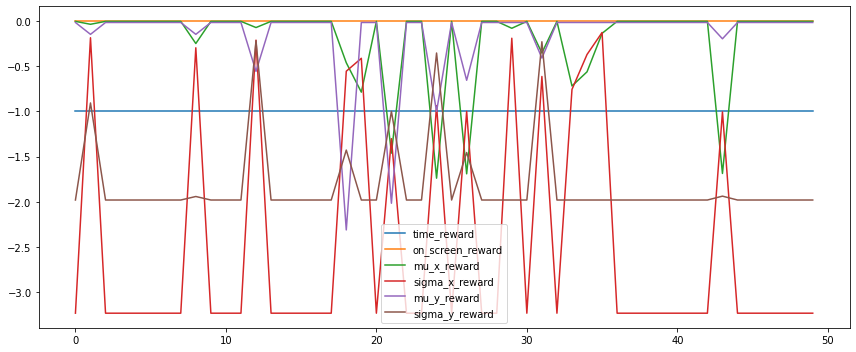

In [10]:
# env = ARESEA()
env = FilterAction(env, [0,1,3], replace=0)
env = TimeLimit(env, 50)
env = RecordData(env)
env = RescaleAction(env, -1, 1)

env.reset()
done = False
while not done:
    observation, reward, done, info = env.step(env.action_space.sample())
    env.render(mode="human")

infos = unwrap_wrapper(env, RecordData).infos

time_reward = [info["time_reward"] for info in infos]
on_screen_reward = [info["on_screen_reward"] for info in infos]
mu_x_reward = [info["mu_x_reward"] for info in infos]
sigma_x_reward = [info["sigma_x_reward"] for info in infos]
mu_y_reward = [info["mu_y_reward"] for info in infos]
sigma_y_reward = [info["sigma_y_reward"] for info in infos]

plt.figure(figsize=(12,5))
plt.plot(time_reward, label="time_reward")
plt.plot(on_screen_reward, label="on_screen_reward")
plt.plot(mu_x_reward, label="mu_x_reward")
plt.plot(sigma_x_reward, label="sigma_x_reward")
plt.plot(mu_y_reward, label="mu_y_reward")
plt.plot(sigma_y_reward, label="sigma_y_reward")
plt.legend()
plt.tight_layout()
plt.show()

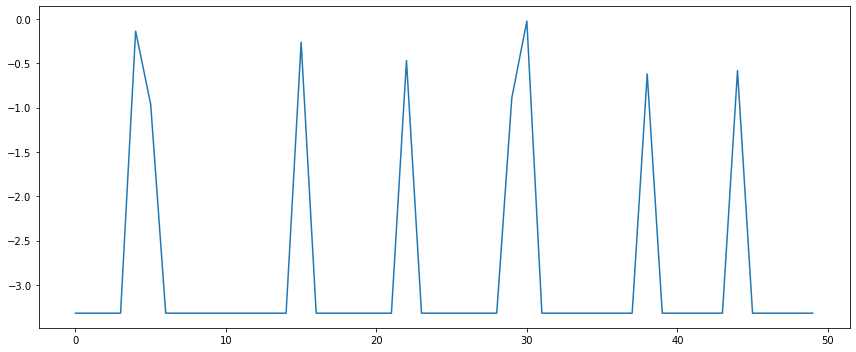

In [5]:
plt.figure(figsize=(12,5))
plt.plot(unwrap_wrapper(env, RecordData).rewards)
plt.tight_layout()
plt.show()

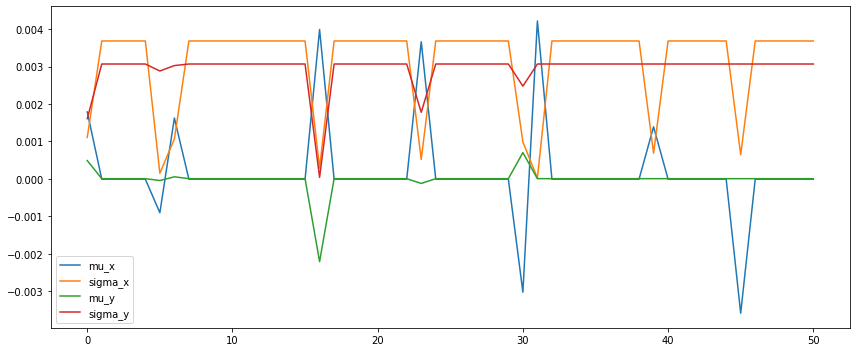

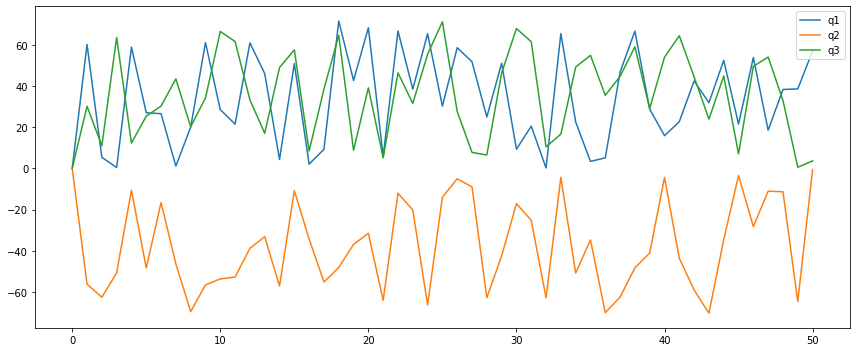

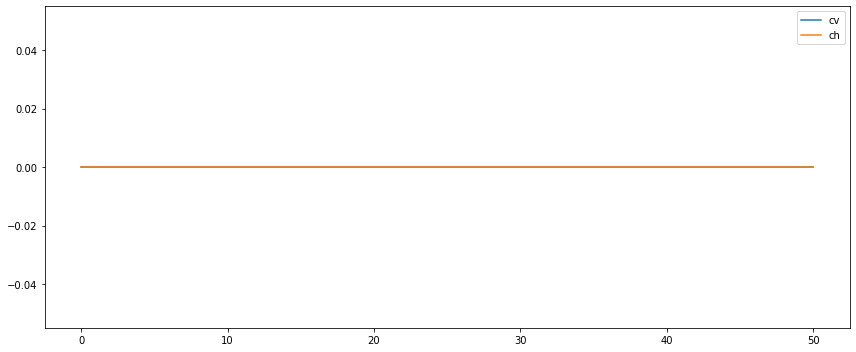

In [6]:
observations = unwrap_wrapper(env, RecordData).observations

mu_x = [observation["beam"][0] for observation in observations]
sigma_x = [observation["beam"][1] for observation in observations]
mu_y = [observation["beam"][2] for observation in observations]
sigma_y = [observation["beam"][3] for observation in observations]

q1 = [observation["magnets"][0] for observation in observations]
q2 = [observation["magnets"][1] for observation in observations]
cv = [observation["magnets"][2] for observation in observations]
q3 = [observation["magnets"][3] for observation in observations]
ch = [observation["magnets"][4] for observation in observations]

plt.figure(figsize=(12,5))
plt.plot(mu_x, label="mu_x")
plt.plot(sigma_x, label="sigma_x")
plt.plot(mu_y, label="mu_y")
plt.plot(sigma_y, label="sigma_y")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(q1, label="q1")
plt.plot(q2, label="q2")
plt.plot(q3, label="q3")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(cv, label="cv")
plt.plot(ch, label="ch")
plt.legend()
plt.tight_layout()
plt.show()

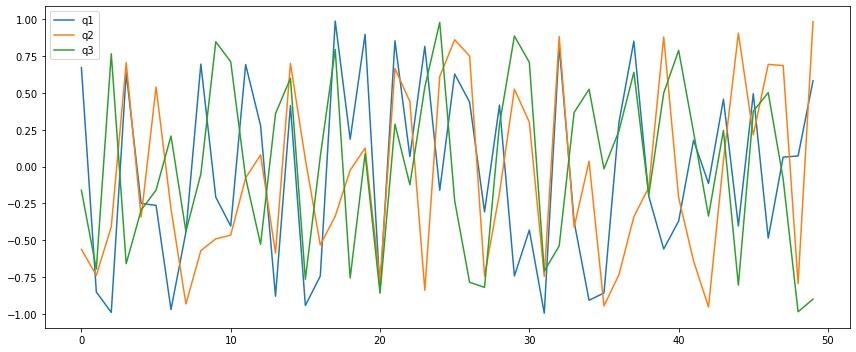

In [7]:
actions = unwrap_wrapper(env, RecordData).actions

q1 = [action[0] for action in actions]
q2 = [action[1] for action in actions]
q3 = [action[2] for action in actions]

plt.figure(figsize=(12,5))
plt.plot(q1, label="q1")
plt.plot(q2, label="q2")
plt.plot(q3, label="q3")
plt.legend()
plt.tight_layout()
plt.show()

/usr/local/Caskroom/miniconda/base/envs/rl39/lib/python3.9/site-packages/gym/wrappers/record_video.py:41: UserWarning: WARN: Overwriting existing videos at /Users/jankaiser/Documents/DESY/ares-ea-rl/recordings_test folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


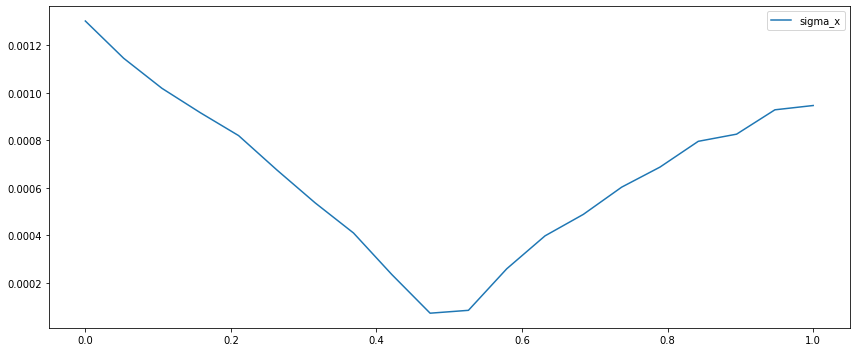

In [11]:
# env = ARESEACheetah(is_fully_observable=True)
env = ARESEADOOCS()
env = FilterAction(env, [3], replace=0)
env = RecordVideo(env, video_folder="recordings_test")
env = RecordData(env)
env = RescaleAction(env, -3, 3)

k1s = np.linspace(0, 1, num=20)

observation = env.reset()
done = False
for k1 in k1s:
    observation, reward, done, info = env.step(k1)
env.close()

observations = unwrap_wrapper(env, RecordData).observations

sigma_x = [obs["beam"][1] for obs in observations]

plt.figure(figsize=(12,5))
plt.plot(k1s, sigma_x[1:], label="sigma_x")
plt.legend()
plt.tight_layout()
plt.show()

/usr/local/Caskroom/miniconda/base/envs/rl39/lib/python3.9/site-packages/gym/wrappers/record_video.py:41: UserWarning: WARN: Overwriting existing videos at /Users/jankaiser/Documents/DESY/ares-ea-rl/recordings_test folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


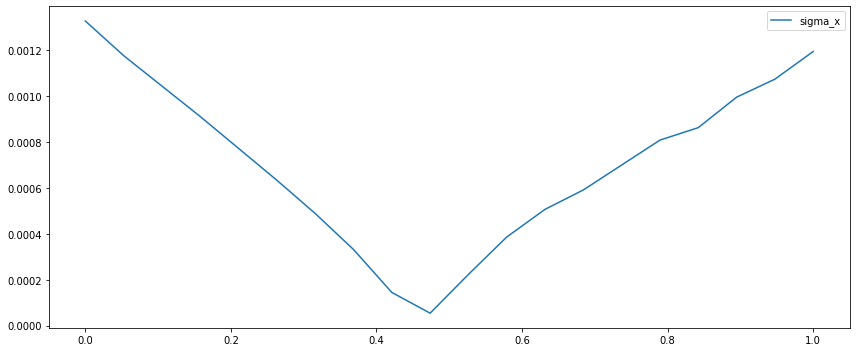

In [12]:
# env = ARESEACheetah(is_fully_observable=True)
env = ARESEADOOCS()
env = FilterAction(env, [1], replace=0)
env = RecordVideo(env, video_folder="recordings_test")
env = RecordData(env)
env = RescaleAction(env, -5, 5)

k1s = np.linspace(0, 1, num=20)

observation = env.reset()
done = False
for k1 in k1s:
    observation, reward, done, info = env.step(k1)
env.close()

observations = unwrap_wrapper(env, RecordData).observations

sigma_x = [obs["beam"][1] for obs in observations]

plt.figure(figsize=(12,5))
plt.plot(k1s, sigma_x[1:], label="sigma_x")
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
# env = ARESEACheetah(is_fully_observable=True)
env = ARESEADOOCS()
env = FilterObservation(env, ["beam","magnets"])
env = FilterAction(env, [0,1,3], replace=0)
env = TimeLimit(env, max_episode_steps=50)
env = RecordData(env)
env = FlattenObservation(env)
env = RescaleAction(env, 0, 3)

check_env(env)

/usr/local/Caskroom/miniconda/base/envs/rl39/lib/python3.9/site-packages/stable_baselines3/common/env_checker.py:272: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


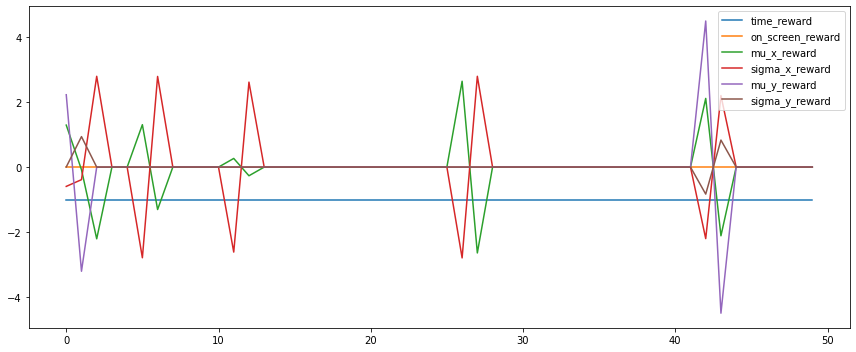

In [15]:
env.reset()
done = False
while not done:
    observation, reward, done, info = env.step(env.action_space.sample())

infos = unwrap_wrapper(env, RecordData).infos

time_reward = [info["time_reward"] for info in infos]
on_screen_reward = [info["on_screen_reward"] for info in infos]
mu_x_reward = [info["mu_x_reward"] for info in infos]
sigma_x_reward = [info["sigma_x_reward"] for info in infos]
mu_y_reward = [info["mu_y_reward"] for info in infos]
sigma_y_reward = [info["sigma_y_reward"] for info in infos]

plt.figure(figsize=(12,5))
plt.plot(time_reward, label="time_reward")
plt.plot(on_screen_reward, label="on_screen_reward")
plt.plot(mu_x_reward, label="mu_x_reward")
plt.plot(sigma_x_reward, label="sigma_x_reward")
plt.plot(mu_y_reward, label="mu_y_reward")
plt.plot(sigma_y_reward, label="sigma_y_reward")
plt.legend()
plt.tight_layout()
plt.show()

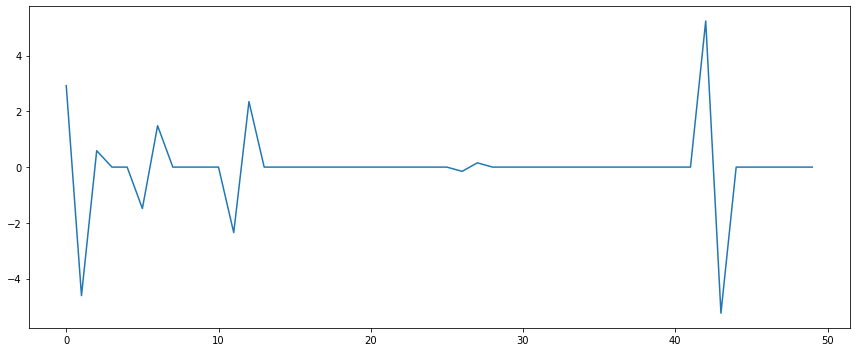

In [16]:
plt.figure(figsize=(12,5))
plt.plot(unwrap_wrapper(env, RecordData).rewards)
plt.tight_layout()
plt.show()

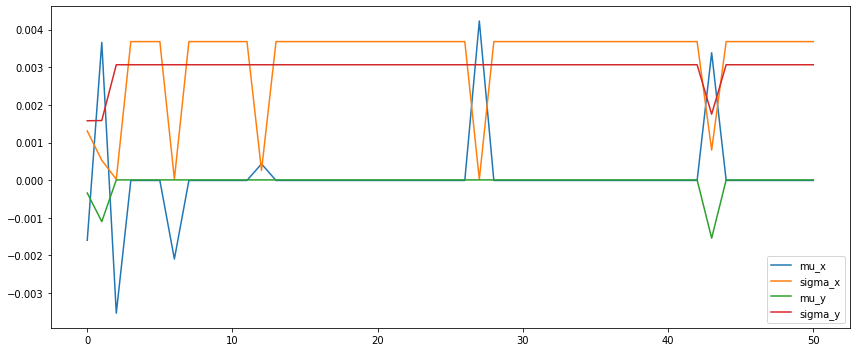

In [17]:
observations = unwrap_wrapper(env, RecordData).observations

mu_x = [observation["beam"][0] for observation in observations]
sigma_x = [observation["beam"][1] for observation in observations]
mu_y = [observation["beam"][2] for observation in observations]
sigma_y = [observation["beam"][3] for observation in observations]

plt.figure(figsize=(12,5))
plt.plot(mu_x, label="mu_x")
plt.plot(sigma_x, label="sigma_x")
plt.plot(mu_y, label="mu_y")
plt.plot(sigma_y, label="sigma_y")
plt.legend()
plt.tight_layout()
plt.show()

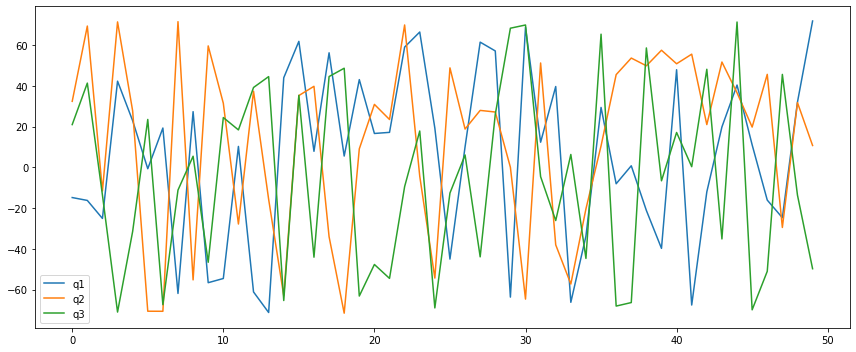

In [18]:
actions = unwrap_wrapper(env, RecordData).actions

q1 = [action[0] for action in actions]
q2 = [action[1] for action in actions]
q3 = [action[2] for action in actions]

plt.figure(figsize=(12,5))
plt.plot(q1, label="q1")
plt.plot(q2, label="q2")
plt.plot(q3, label="q3")
plt.legend()
plt.tight_layout()
plt.show()

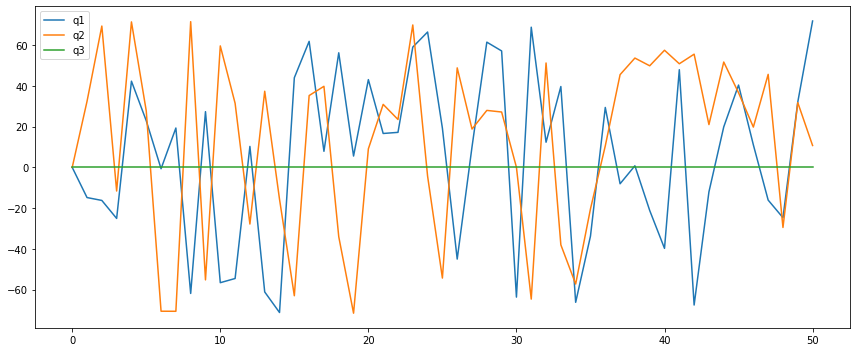

In [20]:
observations = unwrap_wrapper(env, RecordData).observations

q1 = [observation["magnets"][0] for observation in observations]
q2 = [observation["magnets"][1] for observation in observations]
q3 = [observation["magnets"][2] for observation in observations]

plt.figure(figsize=(12,5))
plt.plot(q1, label="q1")
plt.plot(q2, label="q2")
plt.plot(q3, label="q3")
plt.legend()
plt.tight_layout()
plt.show()